# Parallel programming in Julia
#### Pierre Mabille
#### April 22, 2016

### Adding workers

We use multiple processors. I am working with an 8 cores desktop, so I can add 7 processors ("workers") in addition to the main one. You won't get an error message if you try to add more (unless you really add too many of them), but it will not improve performance further by magically creating cores.

If you are using a PC, you can know its number of cores by typing *Ctrl+Alt+Delete*, go to the Task manager, and look at the number of windows below the label "CPU Usage History" (which will also show you the activity of your processors). On a Mac, open the terminal and type *sysctl -n hw.ncpu*. This count includes so-called "multi/hyper-threaded cores" (on Intel processors), which are multiple logical cores created out of a single physical core. 

Whenever you intend to use parallel programming in julia, you should start the file containing the main code by adding additional processors, called "workers". 

In [1]:
addprocs(7)
println("Number of processors:"); println(nprocs())

Number of processors:
8


### Remote calls and remote references

Now let us look at how parallism works in julia.

The function *remotecall(function, processor_nb, vararg)* executes the function *function* on processor number *processor_nb*, where *vararg* are the arguments of the function. Let us for example create a $(2\times 2)$ matrix of uniformly distributed numbers on processor number 2. By default, processor 1 is the main processor from which messages are sent to launch and coordinate jobs on the other processors.

In [2]:
r = remotecall(rand, 2, 2, 2)

RemoteRef{Channel{Any}}(2,1,8)

*remotecall* creates a remote reference *RemoteRef*, which points to the matrix we generated on processor 2. 

The main code returns immediately on processor 1. However, since computations run asynchronously on various processors, processor 2 may not have completed the job assigned by processor 1. The function *isready*, which takes remote references as inputs, returns *true* if it did. This is useful for conditioning statements in the main code. 

The type of the object *r* we created is a *RemoteRef*, so calling *r* directly in the main code in processor 1 won't work. We fetch the actual object the *RemoteRef* is pointing at by using the command *fetch*.

In [3]:
println("Did processor 2 finish the computations?"); println(isready(r))
println("What is r's type?"); println(r)
println("What is r?"); println(fetch(r))

Did processor 2 finish the computations?
true
What is r's type?
RemoteRef{Channel{Any}}(2,1,8)
What is r?
[0.6857857234780877 0.5798774701119049
 0.6477623673822637 0.5684685716995346]


### Macros

The syntax and going-back-and-forth between remote calls and remote references is somewhat cumbersome for large and complex codes. This is where macros come in handy. Their position is at the start of the command to be executed.

*@spawn* runs the code on *some* worker, whose ID is unknow to us at the time we run the command. *@spawnat* folled by the worker's ID allows to choose the worker on which the command is run. The syntax of the former is lighter and should be preferred in general.

Here we add 1 to each of the entries of our matrix *r*. Note that we still need to fetch *r*, because it is defined on processor 2 and we don't know on which processor *@spawn* will run the code. 

In [6]:
s = @spawn 1 .+ fetch(r)
println("Did the processor finish the computations?"); println(isready(s))
println("What is s's type and on which processor was it computed?"); println(s)
println("What is s?"); println(fetch(s))

s2 = @spawnat 3 1 .+ fetch(r)
println("Did the processor finish the computations?"); println(isready(s2))
println("What is s's type and on which processor was it computed?"); println(s2)
println("What is s?"); println(fetch(s2))

Did the processor finish the computations?
false
What is s's type and on which processor was it computed?
RemoteRef{Channel{Any}}(4,1,20)
What is s?
[1.6857857234780877 1.579877470111905
 1.6477623673822637 1.5684685716995346]
Did the processor finish the computations?
false
What is s's type and on which processor was it computed?
RemoteRef{Channel{Any}}(3,1,23)
What is s?
[1.6857857234780877 1.579877470111905
 1.6477623673822637 1.5684685716995346]


Another extremely useful macro is *@everywhere*. As we saw, an object created on some processor will not be available on others unless we *fetch* it. For instance, if we create a random matrix $B$ on processor 3, we won't be able to invert it on processor 5. Defining this matrix *@everywhere* makes it available to all processors, which can read and modify it. 

In [7]:
B = @spawnat 3 rand(10,10)
i = remotecall(inv,5,B)
fetch(i)

LoadError: LoadError: On worker 5:
MethodError: `inv` has no method matching inv(::RemoteRef{Channel{Any}})
 in anonymous at multi.jl:910
 in run_work_thunk at multi.jl:651
 in run_work_thunk at multi.jl:660
 in anonymous at task.jl:58
while loading In[7], in expression starting on line 3

In [8]:
@everywhere B = rand(10,10)
i = remotecall(inv,5,B)
fetch(i)

10x10 Array{Float64,2}:
  1.31691     1.11619    0.0590151  …  -0.882174   -2.03266  -0.788132
  1.38902     1.58851    0.16104        1.11528    -3.83538  -1.51552 
  2.73756     2.0579    -1.35635        0.218679   -4.19781  -3.49267 
 -2.28582    -1.22763    0.660008       0.170134    2.90604   1.35682 
 -2.49942    -0.968241  -0.0576566      0.0697848   3.75867   2.63068 
 -1.62723    -0.892431  -0.0469482  …  -0.13082     3.75347   1.02696 
  0.237975   -0.146719  -0.125828       0.51816    -1.75107  -0.321294
  0.795711    2.01524    0.0546999      0.430407   -2.74638  -1.62258 
  0.0698368  -0.60776   -0.310597      -1.00811     1.95402   1.07503 
  0.485333   -2.03081    0.79794       -0.51281     1.30515   1.19486 

This is especially true for large and complex codes, where code files, modules and types loaded and/or defined on the main processor should be defined *@everywhere*, as the growth model example below makes clear. 

### Parallel maps and parallel loops

In practice, parallel maps and parallel loops are the easiest way to do parallel programming in Julia. 
* *pmap* is better suited for complex computation. It has the same snytax as *map*. Its arguments are ranges of objects whose type depend on the function at hand.
* *@parallel for* loops should be used when every iteration involves a small amount of computations. *@parallel* is another macro that automatically parallelizes tasks across workers. Parallel loops running on multiple processors accept outside variables (e.g. vectors, matrices defined in the main code) if they are read-only. Otherwise if each processor modifies the object at hand, parallel loops should be combined with *SharedArray*s, so that the information added by each worker is made available to other workers.

An example of *@parallel for* loop is given in the growth model below.

Let us give an example for *pmap*. We create a function that generates two random matrices of given sizes, inverts and sums them. We apply it to a collection of matrix sizes, and time the excution for *map* and *pmap*. You can check that they return the same collection of matrices.

In [15]:
@everywhere function change_matrix(nA::Int64, nB::Int64)
    A = rand(nA, nA)
    B = rand(nB, nB)
    nmin = min(nA,nB)
    A = A[1:nmin,1:nmin]
    B = B[1:nmin,1:nmin]
    return inv(A) .+ inv(B)
end

@time map(change_matrix, 1:2, 2:3);
@time pmap(change_matrix, 1:2, 2:3);

@time map(change_matrix, 100:200, 200:300);
@time pmap(change_matrix, 100:200, 200:300);

  0.010229 seconds (9.03 k allocations: 415.130 KB)
  0.009455 seconds (451 allocations: 44.234 KB)
  0.274861 seconds (5.97 k allocations: 208.271 MB, 17.90% gc time)
  0.144038 seconds (129.75 k allocations: 22.908 MB, 1.64% gc time)


# Neoclassical growth model 

Let us look at a stripped-down version of the neoclassical growth model. The environment is deterministic. Capital $k$ is the only state variable, and there is no depreciation. A representative agent solve the following recursive problem:

$$ V(k) = \max_{c \in (0,f(k))} u(c) + \beta V(k')$$
$$ k' = f(k) - c$$
$$ f(k) = k^\alpha$$

where $\alpha<1$ and the instantaneous utility function $u$ satisfies the Inada conditions.

We solve the model by value function iteration with interpolation of the value function. We compare the speed of the serial solution against the parallel one, for various grids.

## Serial solution

We use a single processor. 

We start by loading the modules on the local processor, and define the model parameters. Then we define three functions to solve the model:
* *optim_step(k, Vtilde_itp)* solves for the consumption policy function given a state $k$ and an interpolant for the continuation value $Vtilde\_itp$.
* *vfi_map(grid_k, criterion)* solves the model by value function iteration given a capital grid $grid\_k$ and a convergence criterion $criterion$. It uses the function *map* to compute the value function at the next iteration.
* *vfi_loop(grid_k, criterion)* solves the model by value function iteration given a capital grid $grid\_k$ and a convergence criterion $criterion$. It uses a *for* loop to compute the value function at the next iteration.

In [46]:
using Optim: optimize
using Interpolations
using PyPlot

## Primitives and grid
alpha = 0.65
beta = 0.95
grid_max = 2
grid_size = 1500
grid_k = linspace(1e-6,grid_max,grid_size)
u(c) = log(c)

function optim_step(k,Vtilde_itp)
    objective(c) = -u(c) - beta*Vtilde_itp[k^alpha - c]
    res = optimize(objective,1e-6,k^alpha)
    c_star = res.minimum
    V1 = -objective(c_star)
    return V1
end

function vfi_map(grid_k,criterion)
    knots = (grid_k,) # knots for gridded linear interpolations
    iter = 0
    V0 = 5 .* log(grid_k)
    distance = 1
    while distance > criterion
        Vtilde_itp = interpolate(knots, V0, Gridded(Linear()))
        V1 = map(k -> optim_step(k,Vtilde_itp), grid_k)
        distance = norm(V1-V0, Inf)
        V0 = deepcopy(V1)
        iter = iter + 1
    end
    return V0
end

function vfi_loop(grid_k,criterion)
    knots = (grid_k,) # knots for gridded linear interpolations
    iter = 0
    V0 = 5 .* log(grid_k)
    V1 = Array(Float64,length(grid_k))
    distance = 1
    while distance > criterion
        Vtilde_itp = interpolate(knots, V0, Gridded(Linear()))
        for (i,k) in enumerate(grid_k)
            objective(c) = -u(c) - beta*Vtilde_itp[k^alpha - c]
            res = optimize(objective,1e-6,k^alpha)
            c_star = res.minimum
            V1[i] = -objective(c_star)
        end
        distance = norm(V1-V0)
        V0 = deepcopy(V1)
        iter = iter + 1
    end
    return V0
end

vfi_loop (generic function with 2 methods)

We time the execution of the *optim_loop* function for capital grids of various lengths. The two functions *vfi_loop* and *vfi_map* have similar performance.

In [47]:
grid_size_array = [150 500 1000 1500 10000]
grids = Array(Any, length(grid_size_array))
for (i,g) in enumerate(grid_size_array)
    grids[i] = linspace(1e-6,grid_max,g)
end

for g in grids
    @time V=vfi_loop(g,1e-6);
end

  1.682615 seconds (58.33 M allocations: 917.355 MB, 3.52% gc time)
  4.851052 seconds (181.33 M allocations: 2.790 GB, 3.71% gc time)
  9.309212 seconds (353.08 M allocations: 5.440 GB, 3.59% gc time)
 13.839599 seconds (526.36 M allocations: 8.114 GB, 3.62% gc time)
 99.549924 seconds (3.63 G allocations: 56.005 GB, 6.19% gc time)


## Parallel execution

Start by loading the modules on the main processor. Then define load modules *@everywhere*, i.e. on every working processor. It is often needed to load modules on the main processor first, to prevent them from overwriting each other. Also define the model parameters and functions *@everywhere*. 

The function *optim_step(k,Vtilde_itp)* is identical to the serial case. This is the step of the resolution of the model that we choose to parallelize. That is, we delegate the maximization of the value function for various values of $k$ to several processors.

Then we gather the optimal values computed by the various processors into a *SharedArray*. This is what the function *vfi_ploop(grid_k,criterion)* does. 

At every iteration of the value function iteration, it delegates the various maximization problems to the various workers using a *@parallel for* loop (the macro *@sync* ensures that the program waits for all workers to complete their tasks before it goes on). 

The *SharedArray* makes the information contained in it readable for all workers. This is not strictly necessary here (we could have used a *DArray* -- a distributed array), but it is often more convenient to code up. 

In [1]:
## (Just for illustration, modules already loaded above)
using Optim: optimize
using Interpolations
using PyPlot

@everywhere begin
    using Optim: optimize
    using Interpolations
    
    ## Primitives and grid
    alpha = 0.65
    beta = 0.95
    grid_max = 2
    grid_size = 1500
    grid_k = linspace(1e-6,grid_max,grid_size)
    u(c) = log(c)

    function optim_step(k,Vtilde_itp)
        objective(c) = -u(c) - beta*Vtilde_itp[k^alpha - c]
        res = optimize(objective,1e-6,k^alpha)
        c_star = res.minimum
        V1 = -objective(c_star)
        return V1
    end
   
    function vfi_ploop(grid_k,criterion)
        knots = (grid_k,)
        iter = 0
        V0 = 5 .* log(grid_k)
        distance = 1
        while distance > criterion
            Vtilde_itp = interpolate(knots, V0, Gridded(Linear()))
            V1 = SharedArray(Float64,length(grid_k))
            @sync @parallel for i in eachindex(grid_k)
                V1[i] = optim_step(grid_k[i],Vtilde_itp)
            end
            distance = norm(V1-V0, Inf)
            V0 = deepcopy(V1)
            iter = iter + 1
        end
        return V0
    end

end

Number of processors:
8


In [6]:
@everywhere begin
    grid_size_array = [150 500 1000 1500 10000]
    grids = Array(Any, length(grid_size_array))
    for (i,g) in enumerate(grid_size_array)
        grids[i] = linspace(1e-6,grid_max,g)
    end
end

V = Array(Any, length(grids))
for (i,g) in enumerate(grids)
    @time V[i] = vfi_ploop(g,1e-6);
end

  2.055595 seconds (4.95 M allocations: 363.230 MB, 2.03% gc time)
  2.907471 seconds (4.64 M allocations: 353.288 MB, 1.21% gc time)
  4.289460 seconds (4.64 M allocations: 371.430 MB, 0.89% gc time)
  5.501156 seconds (4.65 M allocations: 389.692 MB, 0.80% gc time)
 26.238703 seconds (4.67 M allocations: 400.790 MB, 0.18% gc time)


A few remarks:
* The parallel solution for the first (smallest) grid runs longer than the next two solutions. 
* The serial solution does better than the parallel solution for the smallest grid, but not for larger grids. This illustrates the parallel programming trade-off between communication overhead and execution speed. 
* The speed of the parallel solution increases exponentially compared to the serial solution. 

To complete the exercise, let us plot the various value functions obtained for various grid precisions.

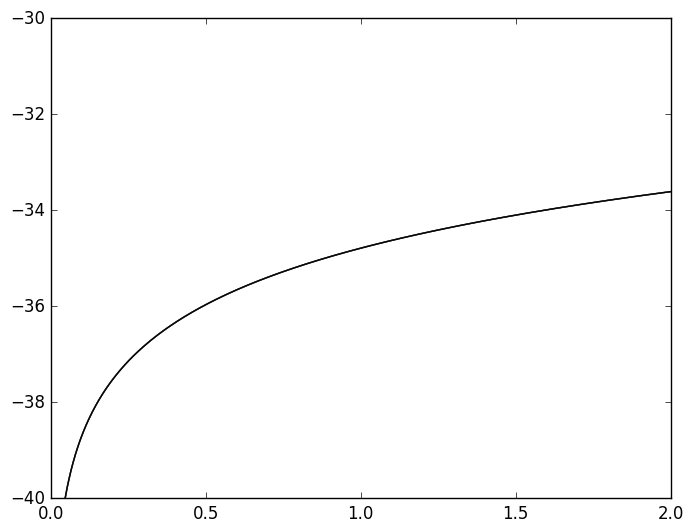

PyObject <bound method Axes.legend of <matplotlib.axes._subplots.AxesSubplot object at 0x000000002F184198>>

In [25]:
fig, ax = subplots()
for i in 1:length(grids)
    x = grids[i]
    y = V[i]
    ax[:set_ylim](-40, -30)
    ax[:set_xlim](minimum(grids[i]), maximum(grids[i])) 
    ax[:plot](x, y, "k-", lw=1, alpha=0.5, label = "draw $i")
end
ax[:legend]